In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

from PIL import Image
from fea.fea2d_mesh import SquareMeshElastic
from fea.fea2d_elasticity import ElasticFEM2D
from fea.img_process import project_input
from fea.boundary import define_boundary_nodes

## Define the domain

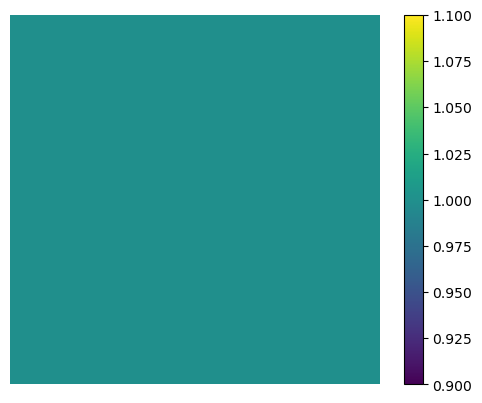

In [2]:
def plot_image(img):
    plt.figure()
    im1 = plt.imshow(img, origin='lower')
    plt.axis('off')
    plt.colorbar(im1)
    
imarray = np.ones((50,50))
plot_image(imarray)

## Define the loading

In [3]:
def loading_type1(node_mask, bc):
    '''
    boundary node list: [top, bottom, left, right, curved]
    
    Loading (0 is x, 1 is y direction): 
    Fix the top boundary, apply random loading at bottom boundary
    '''
    h, w = node_mask.shape
    top_idx = np.where(bc[0][0] == 1)
    bottom_idx = np.where(bc[1][0] == 1)
    left_idx = np.where(bc[2][0] == 1)
    right_idx = np.where(bc[3][0] == 1)
    curved_idx = np.where(bc[4][0] == 1)

    # define dirich boundary (use for FEA and FEA-Net)
    dirich_idx = np.zeros((h, w, 2), dtype=np.int32)
    dirich_idx[left_idx[0], left_idx[1], 0] = 1 # fix left displacement in x
    dirich_idx[top_idx[0], top_idx[1], 1] = 1 # fix top displacement in y
    dirich_value = np.zeros_like(dirich_idx)

    dirich_idx_feanet = np.logical_not(dirich_idx).astype(int)
    dirich_idx_feanet *= node_mask.reshape(h,w,1)

    # define traction boundary, 1.0 traction boundary; 0 else
    traction_idx = np.zeros((h, w, 2), dtype=np.int32)
    traction_value = np.zeros_like(traction_idx)
    traction_idx[bottom_idx[0], bottom_idx[1], 1] = 1 
    traction_value[bottom_idx[0], bottom_idx[1], 1] = 10 # apply bottom force in y, N

    return dirich_idx, dirich_idx_feanet, dirich_value, traction_idx, traction_value

## Define the problem

In [4]:
hsize = 0.02 #mm, plate size = 0.02*50=1mm
elem_mask = np.copy(imarray)
h, w = elem_mask.shape
material = np.ones((h, w, 2))
material[:,:,0] *= 110e3 # E, MPa
material[:,:,1] *= 0.34 # v
node_mask = project_input(elem_mask)


# define boundary nodes and connections
bc = define_boundary_nodes(elem_mask) # top, bottom, left, right, curved
neumann_connlist = [bc[1][1]]
dirich_idx, dirich_idx_feanet, dirich_val, neumann_idx, neumann_val = loading_type1(node_mask, bc)
f_val = np.zeros_like(dirich_val)

In [5]:
# generate a mesh grid
grid = SquareMeshElastic(hsize, elem_mask, dirich_idx, neumann_connlist, outfile = None)

In [6]:
# generate FEM problem
problem = ElasticFEM2D(grid, 'plane_stress', material, dirich_val.reshape(-1), neumann_val.reshape(-1), f_val.reshape(-1))

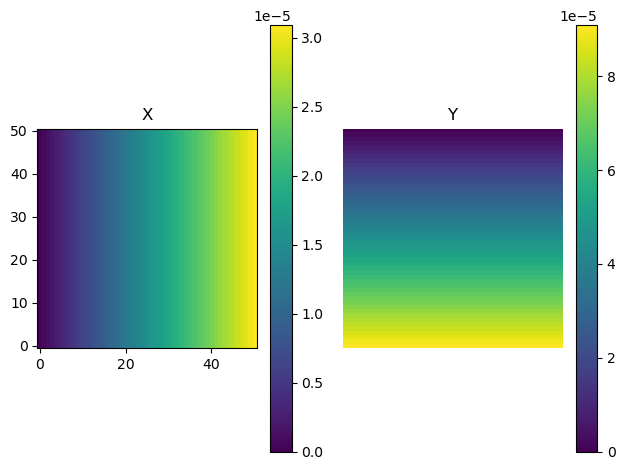

In [7]:
problem.Solve('direct')
problem.PlotField(2)

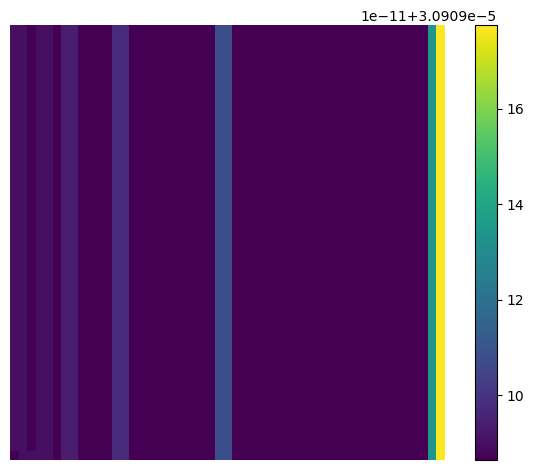

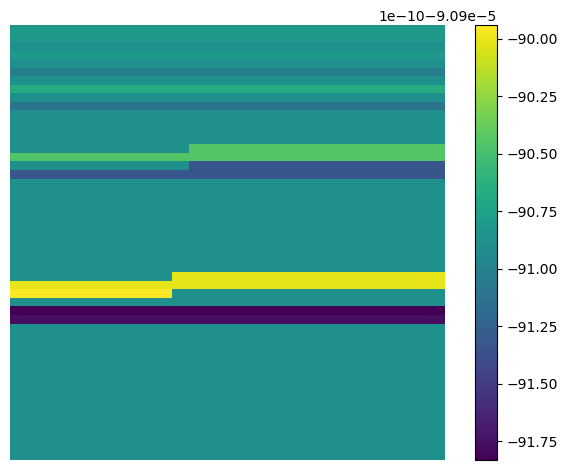

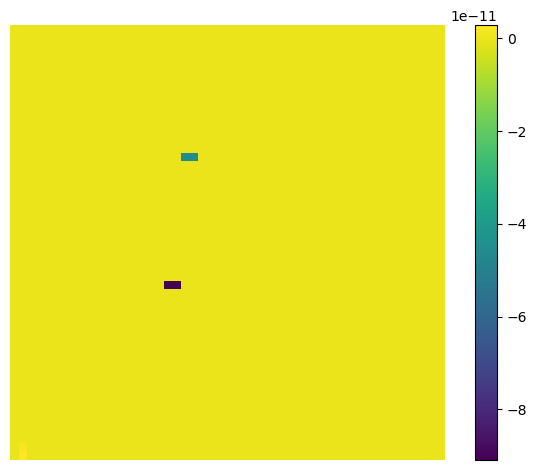

In [8]:
problem.ComputeStrainStress()
problem.PlotField(1, problem.strain[:,0])
problem.PlotField(1, problem.strain[:,1])
problem.PlotField(1, problem.strain[:,2])

In [12]:
problem.strain[:,0]

array([3.0909086e-05, 3.0909090e-05, 3.0909090e-05, ..., 3.0909086e-05,
       3.0909134e-05, 3.0909177e-05], dtype=float32)